In [119]:
import tensorflow as tf
import pandas as pd
import nltk
import requests
import os
import subprocess
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import re
import numpy as np

In [120]:
def set_seed(seed):
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

set_seed(42)

In [121]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\souss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\souss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def download_and_extract_rar(url, output_dir="extracted_data"):
    """
    Downloads a .rar file from a given URL and extracts it.

    Parameters:
        url (str): Direct URL to the .rar file.
        output_dir (str): Directory to extract the contents.
    """
    file_name = "data.rar"

    # Download the file
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        print("Download complete.")
    else:
        print("Failed to download the file. Check the URL.")
        return

    # Create output directory if not exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract the .rar file (requires unrar installed)
    try:
        subprocess.run(["unrar","x" , file_name, output_dir], check=True)
        print(f"Extraction complete. Files are in '{output_dir}'")
    except FileNotFoundError:
        print("Error: 'unrar' is not installed. Install it using 'sudo apt install unrar' or 'brew install unrar'.")

# Example usage
download_and_extract_rar("https://github.com/desire-del/ramadan-league/raw/main/2.%20Sentiment%20Sleuth/data.rar")


In [4]:
def read_data(path):
  df = pd.read_csv(path)
  return df[["text", "target"]]

df = read_data("extracted_data/data.csv")
df.head()

,text,target
0,two more days in mexico,0
1,Good morning,4
2,listing to movies by sleepdistrict,4
3,I dont like working when its sunny,0
4,"@somesheep thanks, a nice one and I didn't kno...",4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960000 entries, 0 to 959999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    960000 non-null  object
 1   target  960000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 14.6+ MB


In [6]:
df.describe()

,target
count,960000.000000
mean,1.998871
std,2.000001
min,0.000000
25%,0.000000
50%,0.000000
75%,4.000000
max,4.000000


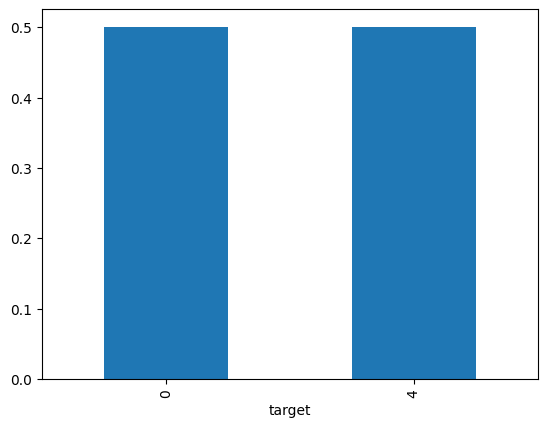

In [7]:
df['target'].value_counts(normalize=True).plot(kind='bar')
plt.show()

In [8]:
df.duplicated().sum()

7981

In [9]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [10]:
def create_datasets(df, train_size):
  X_train, X_test, y_train, y_test = train_test_split(df["text"], df["target"],
                                                      train_size=train_size, stratify=df["target"], random_state=42)
  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

  return train_dataset, test_dataset

In [11]:
df['target'] = (df['target'] == 4).astype(int)
df.head()

,text,target
0,two more days in mexico,0
1,Good morning,1
2,listing to movies by sleepdistrict,1
3,I dont like working when its sunny,0
4,"@somesheep thanks, a nice one and I didn't kno...",1


In [123]:
train_dataset, test_dataset = create_datasets(df, train_size=0.7)
print(f'Train data shape : {train_dataset.cardinality()}')
print(f'Test data shape : {test_dataset.cardinality()}')

Train data shape : 666413
Test data shape : 285606


In [124]:
for text, target in train_dataset.take(1):
    print(f"Text: {text}")
    print(f"Target: {target}")

Text: b"@JasonPMcRussell c'mon I'll clean your room if you pay me! "
Target: 0


In [125]:
STOPWORDS = set(stopwords.words('english'))

In [127]:
import tensorflow as tf

def standard_func(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, r'[^\w\s]', '')  # Raw string
    text = tf.strings.regex_replace(text, r'\s+', ' ')  # Raw string
    text = tf.strings.strip(text)

    # Drop URL
    text = tf.strings.regex_replace(text, r'http[s]?://\S+', '')  # Raw string

    # Drop mentions (@username)
    text = tf.strings.regex_replace(text, r'@\w+', '')  # Raw string

    # Drop hashtags (#hashtag)
    text = tf.strings.regex_replace(text, r'#\w+', '')  # Raw string

    # Drop stopwords
    for word in STOPWORDS:
        if word[0] == "'":
            text = tf.strings.regex_replace(text, rf"{word}\b", "")
        else:
            text = tf.strings.regex_replace(text, rf"\b{word}\b", "")

    # Remove punctuation (second pass)
    text = tf.strings.regex_replace(text, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")

    return text


In [128]:
sample = next(iter(train_dataset))
print(sample)
print(standard_func(sample[0]))

(<tf.Tensor: shape=(), dtype=string, numpy=b"@JasonPMcRussell c'mon I'll clean your room if you pay me! ">, <tf.Tensor: shape=(), dtype=int32, numpy=0>)
tf.Tensor(b'jasonpmcrussell cmon ill clean  room   pay ', shape=(), dtype=string)


In [129]:
VOCAB_SIZE = 30000
MAX_LENGTH = 200
EMBEDDING_DIM = 128
TRAIN_BATCH_SIZE = 32

In [130]:
def fit_vectorizer(text_only_dataset, standard_func):
  vectorizer = tf.keras.layers.TextVectorization(
      standardize=standard_func,
      max_tokens=VOCAB_SIZE,
  )
  vectorizer.adapt(text_only_dataset)

  return vectorizer

In [22]:
"""
keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_dataset.map(lambda x, y: standard_func(x)),
    vocabulary_size=VOCAB_SIZE,
    reserved_tokens=["[PAD]", "[UNK]"],
    vocabulary_output_file="vocab.txt"
)
"""

'\nkeras_nlp.tokenizers.compute_word_piece_vocabulary(\n    train_dataset.map(lambda x, y: standard_func(x)),\n    vocabulary_size=VOCAB_SIZE,\n    reserved_tokens=["[PAD]", "[UNK]"],\n    vocabulary_output_file="vocab.txt"\n)\n'

In [131]:
text_only_dataset = train_dataset.map(lambda x, y: x)
label_only_dataset = train_dataset.map(lambda x, y: y)

In [132]:
vectorizer = fit_vectorizer(text_only_dataset, standard_func)

In [133]:
print(f'Vocabulary size : {vectorizer.vocabulary_size()}')


Vocabulary size : 30000


In [134]:
PADDING_TYPE = "pre"
TRUNCATING_TYPE = "post"

In [135]:
def preprocessing_fn(dataset:tf.data.Dataset) -> tf.data.Dataset:
  dataset = dataset.map(lambda x, y: (vectorizer(x), y))
  dataset = dataset.ragged_batch(
      batch_size = dataset.cardinality()
  )
  sequences, labels = dataset.get_single_element()
  sequences = tf.keras.utils.pad_sequences(
      sequences.numpy(),
      maxlen=MAX_LENGTH,
      padding=PADDING_TYPE,
      truncating=TRUNCATING_TYPE
  )
  sequences = tf.data.Dataset.from_tensor_slices(sequences)
  labels = tf.data.Dataset.from_tensor_slices(labels)
  dataset = tf.data.Dataset.zip((sequences, labels))


  return dataset

In [136]:
print(next(iter(train_dataset.map(lambda x, y: (vectorizer(x), y)).take(1))))

(<tf.Tensor: shape=(6,), dtype=int64, numpy=array([   1, 3124,   42,  607,  308,  435], dtype=int64)>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


In [137]:
train_dataset = train_dataset.apply(preprocessing_fn)
test_dataset = test_dataset.apply(preprocessing_fn)

In [138]:
for text, target in train_dataset.take(1):
    print(f"Text: {text}")
    print(f"Target: {target}")

Text: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    1 3124


In [139]:
PREFETCH = tf.data.AUTOTUNE
train_dataset = (train_dataset
                 .cache()
                 .batch(TRAIN_BATCH_SIZE)
                 .prefetch(PREFETCH))
test_dataset = (test_dataset
                .cache()
                .batch(TRAIN_BATCH_SIZE))

In [140]:
VOCAB_SIZE = vectorizer.vocabulary_size()

In [179]:
tf.keras.backend.clear_session()

In [180]:
def create_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(MAX_LENGTH,)),
      tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, recurrent_dropout=0.3)), 
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                 loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [181]:
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,972,097 (15.15 MB)

 Trainable params: 3,972,097 (15.15 MB)

 Non-trainable params: 0 (0.00 B)

In [182]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)

In [183]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/10
20826/20826 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.7173 - loss: 0.5699

20826/20826 ━━━━━━━━━━━━━━━━━━━━ 13588s 652ms/step - accuracy: 0.7173 - loss: 0.5699 - val_accuracy: 0.7550 - val_loss: 0.5077
Epoch 2/10
20826/20826 ━━━━━━━━━━━━━━━━━━━━ 14035s 674ms/step - accuracy: 0.7347 - loss: 0.5538 - val_accuracy: 0.7407 - val_loss: 0.5262
Epoch 3/10
 4184/20826 ━━━━━━━━━━━━━━━━━━━━ 2:40:57 580ms/step - accuracy: 0.7250 - loss: 0.5627

KeyboardInterrupt: 

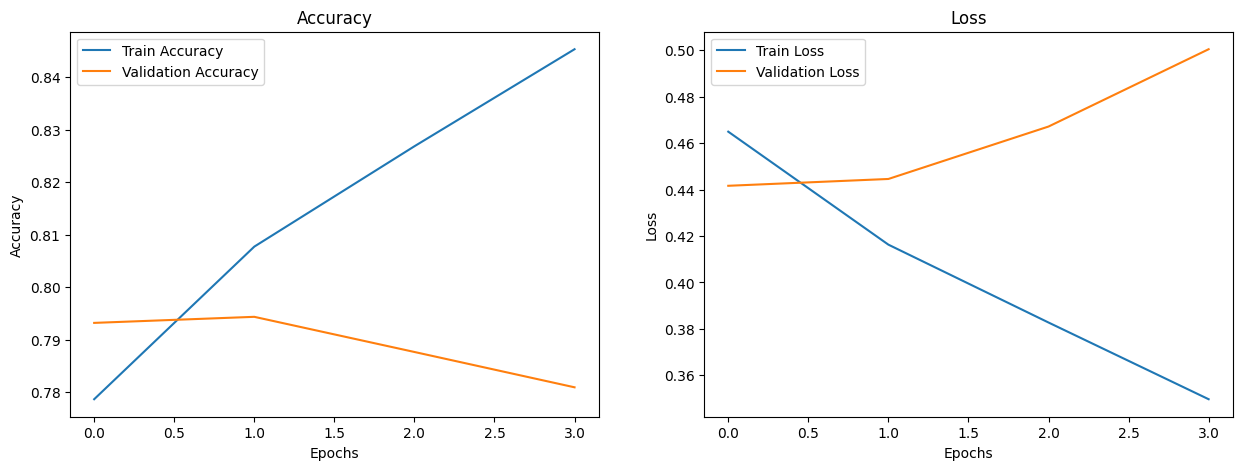

In [150]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    plt.show()

plot_history(history)